In [1]:
import pickle as pkl
import utils
import torch
import matplotlib.pyplot as plt
import time

path_exp = '/home/nina/VRData/Processing/pkls'
path_models = '/home/nina/models'

device = 'cpu'

In [3]:
animal = 'ST260'
day_name = 'Day1'
exp_pref = f'{animal}_{day_name}'
with open(f"{path_models}/order_{exp_pref}.pkl","rb") as f:
    order=pkl.load(f)-5
order

array([  1,  19,  43,  11,  31,  21,  15,  78,   5,  47,  66,  76,  44,
        37,  68,  94,  77,  86,  29,   3,  17,  13,  -4,  10,  -3,  25,
        34,  93,  88,  72,  28,  48,  20,  14,  46,  64,  12,  57,  40,
         8,  45,  58,  49,  60,  27,  83,  55,   4,  95,  92,  56,  59,
        81,  24,  26,  35,  67,  32,  50,  62,  84,   2,   9,  30,  82,
        63,   6,  75,  97,  74,  85,  -2, 100,  96,  91,  16,   7,  53,
        69,  71,  -1,  87,  23,  41,  61,  18,  33,  54,  39, 102,  98,
        42,  70,  99,  73, 101,  22,  80, 103,  52,  -5,  65,  89,  79,
        51,  38,   0,  36,  90])

In [4]:
# transform all
def transform():
    n1=order[0]
    next_layer = []
    for n2 in order[1:]:
        # load model
        likelihoods = utils.get_likelihoods(f"{path_models}/{exp_pref}/summary.pkl",n1,n2)
        if (len(likelihoods)==1) & (likelihoods[0].name=='Independence'):
            next_layer.append(Y[:,0])
        else:
            weights_file = f"{path_models}/{exp_pref}/model_{n1}-{n2}.pth"
            model = utils.get_model(weights_file, likelihoods, device) 
            # load data
            X,Y = utils.load_experimental_data(path_exp, animal, day_name, n2, n1)
            S = torch.tensor(X).float().squeeze().to(device)
            samples = torch.tensor(Y).float().squeeze().to(device)

            with torch.no_grad():
                f_samples = model(S).rsample(torch.Size([10]))
            f_samples.shape

            copula = model.likelihood.get_copula(f_samples.mean(dim=0))

            next_layer.append(copula.ccdf(samples).cpu().numpy())
    return X,next_layer
%time X,next_layer = transform()

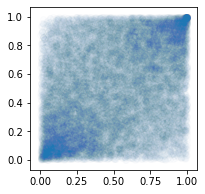

In [101]:
plt.figure(figsize=(3,3))
plt.scatter(next_layer[0],next_layer[1],alpha=0.01)

In [122]:
import numpy as np
data = {}
data['X'] = X
data['Y'] = np.array(next_layer).T

In [125]:
with open(f"{path_exp}/{exp_pref}_layer1.pkl","wb") as f:
    pkl.dump(data,f)

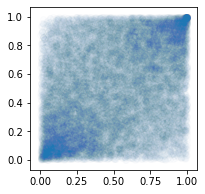

In [4]:
X,Y = utils.standard_loader(f"{path_exp}/{exp_pref}_layer1.pkl",0,1)
plt.figure(figsize=(3,3))
plt.scatter(*Y.T,alpha=0.01)

## Individual pair

In [38]:
n1=order[0]
n2=order[1]
# load model
likelihoods = utils.get_likelihoods(f"{path_models}/{exp_pref}/summary.pkl",n1,n2)
weights_file = f"{path_models}/{exp_pref}/model_{n1}-{n2}.pth"
model = utils.get_model(weights_file, likelihoods, device) 
# load data
X,Y = utils.load_experimental_data(path_exp, animal, day_name, n2, n1)
S = torch.tensor(X).float().squeeze().to(device)
samples = torch.tensor(Y).float().squeeze().to(device)

[0.001 0.001] [0.999 0.999]


In [39]:
with torch.no_grad():
    f_samples = model(S).rsample(torch.Size([10]))
f_samples.shape

torch.Size([10, 3, 21471])

In [50]:
copula = model.likelihood.get_copula(f_samples.mean(dim=0))
model.likelihood.likelihoods

[GumbelCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 ), GumbelCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 )]

tensor(0.2226, device='cuda:1')


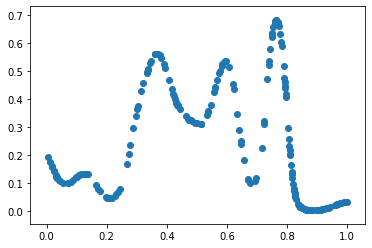

In [51]:
plt.scatter(X[::100],copula.mix.cpu().numpy()[0,::100])
print(copula.mix[0].mean())

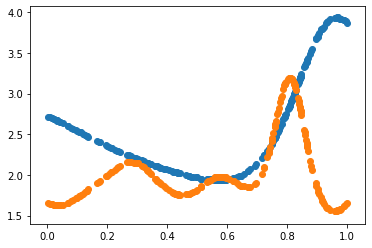

In [52]:
plt.scatter(X[::100],copula.theta.cpu().numpy()[0,::100])
plt.scatter(X[::100],copula.theta.cpu().numpy()[1,::100])

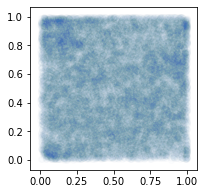

In [53]:
plt.figure(figsize=(3,3))
plt.scatter(copula.ccdf(samples).cpu().numpy(),Y[:,1],alpha=0.01)

In [44]:
new_Y0 = copula.make_dependent(torch.stack([copula.ccdf(samples),samples[...,1]],dim=1))

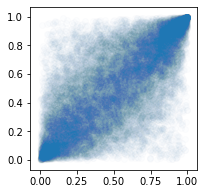

In [45]:
plt.figure(figsize=(3,3))
plt.scatter(*Y.T,alpha=0.01)

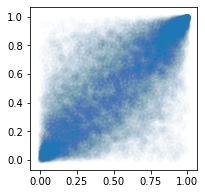

In [46]:
plt.figure(figsize=(3,3))
plt.scatter(new_Y0.cpu().numpy(),Y[:,1],alpha=0.01)

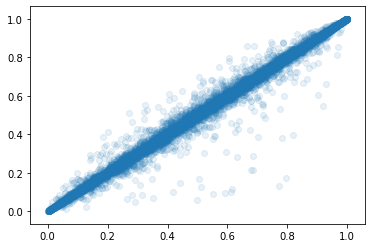

In [47]:
plt.scatter(new_Y0.cpu().numpy(),Y[:,0],alpha=0.1)

In [48]:
x2 = copula.ccdf(samples).cpu().numpy()

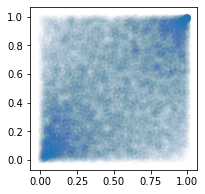

In [49]:
plt.figure(figsize=(3,3))
plt.scatter(x1,x2,alpha=0.01)